# Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Требуется построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

### Загрузка и первичный анализ данных

In [2]:
df_0 = pd.read_csv('geo_data_0.csv')
df_1 = pd.read_csv('geo_data_1.csv')
df_2 = pd.read_csv('geo_data_2.csv')
df_list = [df_0, df_1, df_2]

In [3]:
for df in df_list:
    print(df.head(), '\n')
    print(df.info(), '\n')
    print('Пропусков - ', df.isna().sum(), '\n')
    print('Явных дубликатов - ', df.duplicated().sum(), '\n')

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

Пропусков -  id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Явных дубликатов -  0 

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.4750

**Пропусков нет, явных дубликатов нет, но для признаков потребуется масштабирование. Хотя, есть мнение, что делать это для линейной регрессии [необязательно](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data)**

### Деление данных на выборки

In [4]:
df_train = []
df_valid = []

for df in df_list:
    data_train, data_valid = train_test_split(df, test_size=.25, random_state=2004)
    df_train.append(data_train)
    df_valid.append(data_valid)

### Масштабирование

In [5]:
columns = ['f0', 'f1', 'f2']
scaler = StandardScaler()

for i in range(len(df_train)):
    scaler.fit(df_train[i][columns])
    df_train[i].loc[:,columns] = scaler.transform(df_train[i][columns])
    df_valid[i].loc[:,columns] = scaler.transform(df_valid[i][columns])

### Features & Targets

In [6]:
features_train = []
features_valid = []
target_train = []
target_valid = []

for i in range(len(df_train)):
    features_train.append(df_train[i].drop(['product', 'id'], axis=1))
    features_valid.append(df_valid[i].drop(['product', 'id'], axis=1))
    target_train.append(df_train[i]['product'])
    target_valid.append(df_valid[i]['product'])

### Вывод
**Выполнена подготовка данных:**
- проверено отсутствие пропусков и явных дубликатов в данных
- численные значения отмасштабированы
- данные разделены на обучающую и валидационную выборку в отношении 3:1

Region 0
Коэффициент корреляции параметра f0 и объема сырья 0.1435363509318926
Коэффициент корреляции параметра f1 и объема сырья -0.19235576281513286
Коэффициент корреляции параметра f2 и объема сырья 0.48366328692615235


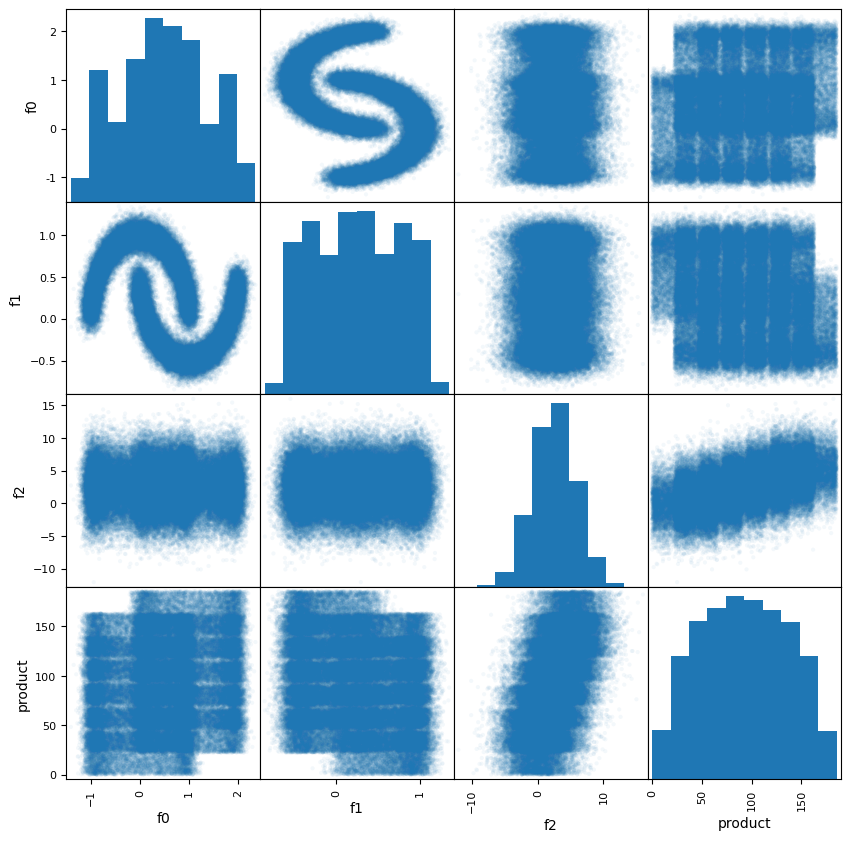

Region 1
Коэффициент корреляции параметра f0 и объема сырья -0.030490530564375243
Коэффициент корреляции параметра f1 и объема сырья -0.010154931786466105
Коэффициент корреляции параметра f2 и объема сырья 0.9993969704906556


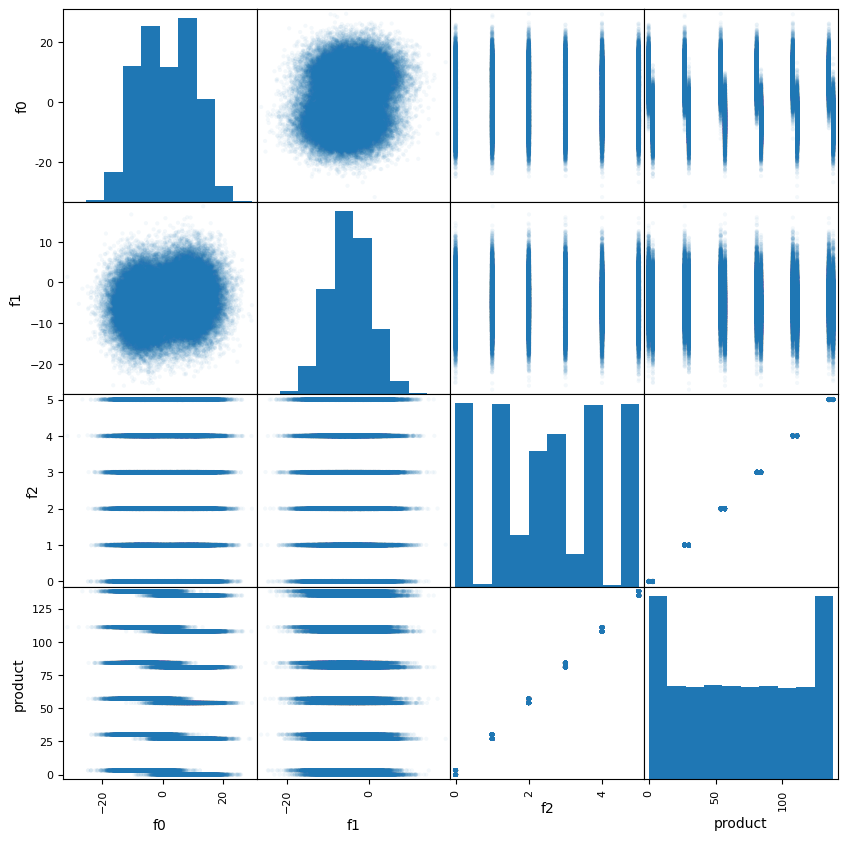

Region 2
Коэффициент корреляции параметра f0 и объема сырья -0.0019870619990491356
Коэффициент корреляции параметра f1 и объема сырья -0.0010123938161309012
Коэффициент корреляции параметра f2 и объема сырья 0.4458710915574206


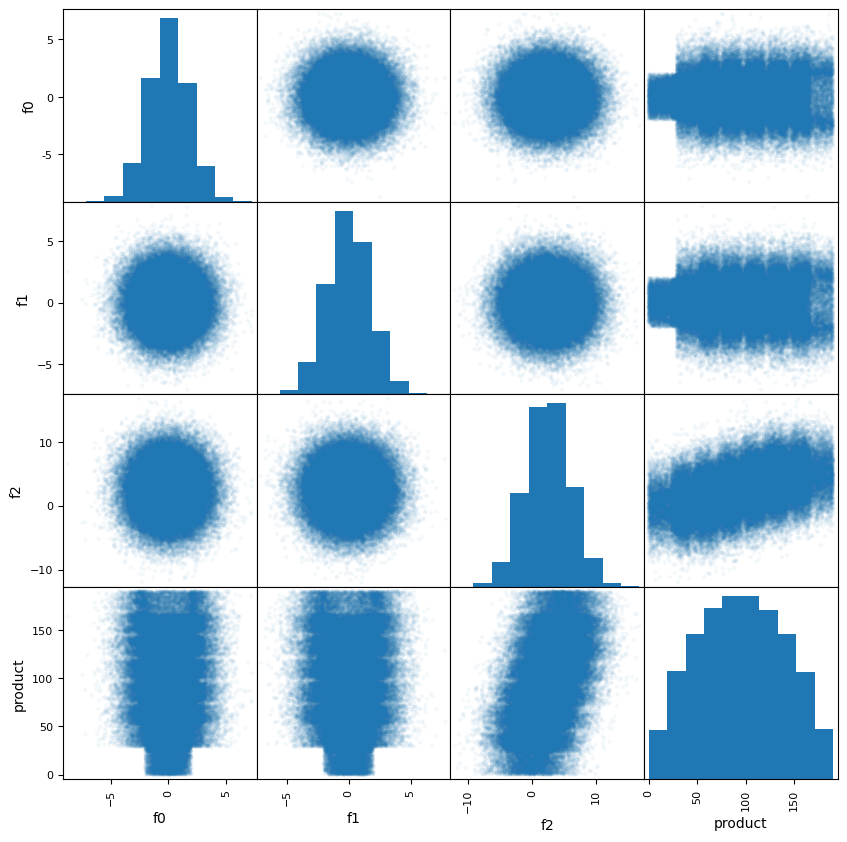

In [7]:
for i in range(len(df_list)):
    print('Region',i)
    df_corr = df_list[i].drop(['product', 'id'], axis=1)
    for column in df_corr.columns:
        c = df_corr[column].corr(df_list[i]['product'])
        print(f'Коэффициент корреляции параметра {column} и объема сырья {c}')
    pd.plotting.scatter_matrix(df_list[i], alpha=.05, figsize=(10,10))
    plt.show()

- о какой-то заметной корреляции запасов сырья и параметров месторождения можно говорить только для параметра f2.
- что касается Региона 1 - для него коэффициент корреляции запаса сырья и параметра f2 близок к 1, что, в совокупности с распределением целевого показателя для этого региона, наводит на мысли, что данные синтетические.
- для Региона 2 хочется отметить, что в отличие от остальных регионов, параметры месторождения практически никак друг от друга не зависят, и диаграммы рассеяния похожи на случайные
</div>

## Обучение и проверка модели

### Обучение модели

**В соответствии с рекомендациями будет использоваться модель линейной регрессии c параметрами по умолчанию**

In [8]:
model = LinearRegression()
predictions = []
mean_product = []
RMSE = []

for i in range(len(features_train)):
    model.fit(X=features_train[i], y=target_train[i])
    predictions.append(pd.Series(model.predict(features_valid[i]), index=features_valid[i].index))
    mean_product.append(predictions[i].mean())
    RMSE.append(mean_squared_error(target_valid[i], predictions[i]) ** 0.5)

In [9]:
for i in range(len(RMSE)):
    print(f'Для региона {i}: \n Cредний предсказанный запас сырья {round(mean_product[i],2)} тыс. баррелей \n RMSE - {round(RMSE[i],2)} тыс. баррелей')

Для региона 0: 
 Cредний предсказанный запас сырья 92.36 тыс. баррелей 
 RMSE - 37.75 тыс. баррелей
Для региона 1: 
 Cредний предсказанный запас сырья 68.55 тыс. баррелей 
 RMSE - 0.9 тыс. баррелей
Для региона 2: 
 Cредний предсказанный запас сырья 94.96 тыс. баррелей 
 RMSE - 40.09 тыс. баррелей


**Интересно, с чем может быть связан такой разброс RMSE. Посмотрим на исходные датасеты еще раз**

Region 0


count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64




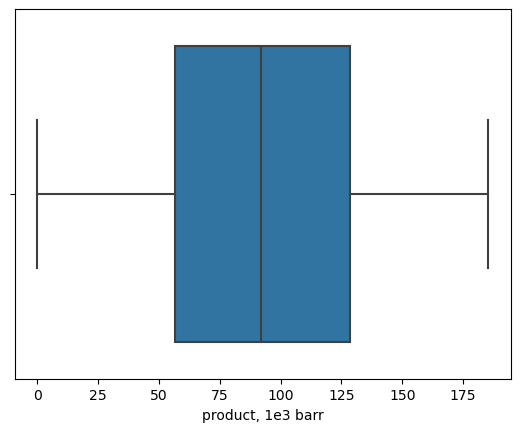

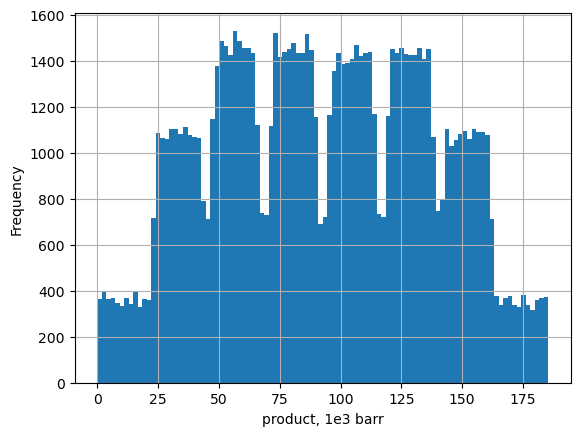

Region 1


count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64




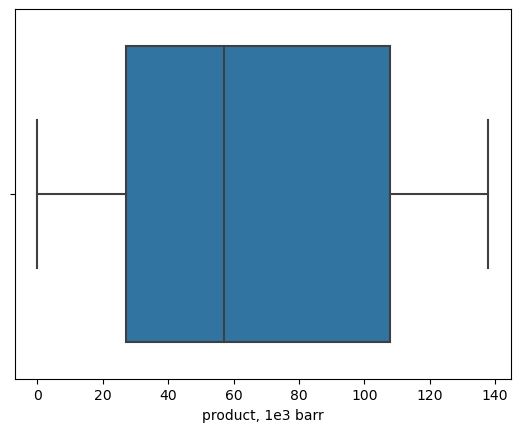

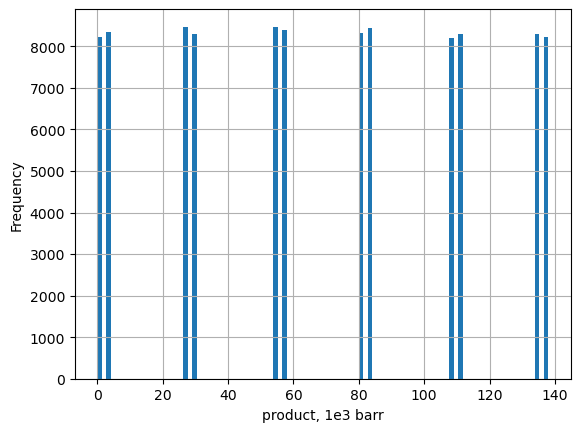

Region 2


count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64




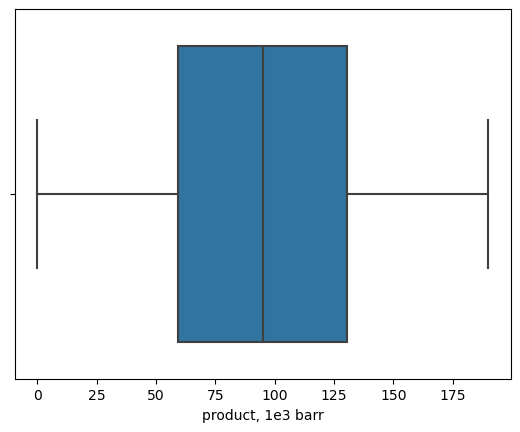

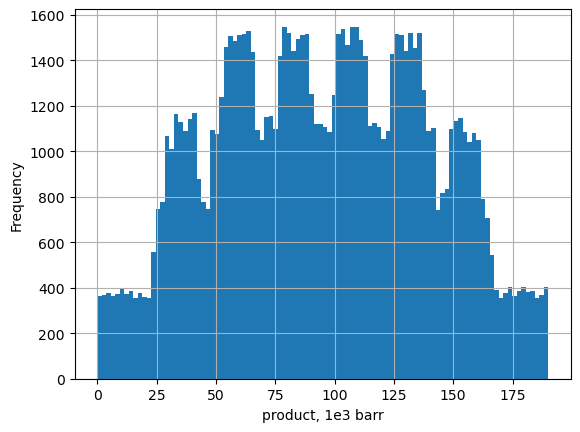

In [10]:
for i in range(len(df_list)):
    print('Region', i)
    print('\n')
    print(df_list[i]['product'].describe())
    print('\n')
    sns.boxplot(x=df_list[i]['product'])
    plt.xlabel('product, 1e3 barr')
    plt.show()
    df_list[i]['product'].hist(bins=100)
    plt.xlabel('product, 1e3 barr')
    plt.ylabel('Frequency')
    plt.show()

### Выводы по результатам обучения модели

- Наиболее перспективными являются Регионы 0 и 2
- Качество предсказаний (по метрике RMSE) для Регионов 0 и 2, мягко говоря, невысокое, следовательно, риск убытков для этих регионов ожидается высокий
- Низкое значение RMSE для региона 1 объясняется тем, что очень много повторяющихся значений целевого признака, которые модель отлично научилась предсказывать.

## Подготовка к расчёту прибыли

### Переменные для расчета выручки и прибыли

In [11]:
PRODUCT_INCOME = 4.5e5 #выручка с единицы продукта
FAIL_PROBABILITY = .025 #максимально допустимая вероятность убытка
REGION_BUDGET = 1e10 #бюджет на разработку скважин в регионе
N_POINTS_REGION = 500 #количество выбранных скважин в регионе
N_POINTS_CHOOSE = 200 #количество разрабатываемых скважин в решионе

min_product = REGION_BUDGET / (N_POINTS_CHOOSE * PRODUCT_INCOME) 
#минимальное количество сырья (тыс. баррелей) в каждой новой скважине для безубыточной добычи
print(round(min_product,2))

111.11


### Выводы

- Подготовлены переменные для дальнейших расчетов бизнес-показателей
- минимальное количество сырья (тыс. баррелей) в каждой новой скважине для безубыточной добычи несколько превышает медианное значение для Регионов 0 и 2 и находится в 75% квантиле для Региона 1

## Расчёт прибыли и рисков 

### Функция для расчета прибыли

In [12]:
def income(target, predictions, n):
    pred_sort = predictions.sort_values(ascending=False)
    best_product = target[pred_sort.index][:n]
    return sum((best_product) * PRODUCT_INCOME) - REGION_BUDGET

### Bootstrap

In [13]:
state = np.random.RandomState(2004)
profit = []
count_fail = [] 
for i in range(len(df_list)):
    p_j = []
    count = 0
    for j in range(1000):
        subsample = target_valid[i].sample(n=N_POINTS_REGION, replace=True, random_state=state)
        predicted_product = predictions[i][subsample.index]  
        p_j.append(income(subsample, predicted_product, N_POINTS_CHOOSE))
        if p_j[j] < 0:
            count += 1
    count_fail.append(count)
    profit.append(pd.Series(p_j))
    print('Region', i)
    print(f'Средняя прибыль - {round(profit[i].mean() / 1e9,2)} млрд руб.')
    print(f'95 % доверительный интервал от {round(profit[i].quantile(.025) / 1e9,2)} млрд руб. до {round(profit[i].quantile(.975) / 1e9,2)} млрд руб.')
    print(f'Риск убытка - {count_fail[i] / 1000:.1%}')
    if count_fail[i] / 1000 < FAIL_PROBABILITY:
        print('Регион рекомендуется к разработке')
    print('\n')

Region 0
Средняя прибыль - 0.46 млрд руб.
95 % доверительный интервал от -0.11 млрд руб. до 1.02 млрд руб.
Риск убытка - 5.0%


Region 1
Средняя прибыль - 0.47 млрд руб.
95 % доверительный интервал от 0.04 млрд руб. до 0.87 млрд руб.
Риск убытка - 1.7%
Регион рекомендуется к разработке


Region 2
Средняя прибыль - 0.34 млрд руб.
95 % доверительный интервал от -0.23 млрд руб. до 0.88 млрд руб.
Риск убытка - 9.4%




### Выводы

- Максимальная средняя выручка ожидается в Регионе 0
- Максимальный риск убытка ожидается в Регионе 2
- Требованиям по уровню риска убытка менее 2,5% удовлетворяет Регион 1, который и рекомендуется к разработке.

## Выводы по проекту

**По результатам проведенного анализа к разработке рекомендуется Регион 1 со средним ожидаемым значением выручки от добычи - 0,47 млрд. руб. и риском убытка 1,7 %**